# A simple example, solved three ways

1. CVXPY + MOSEK
2. SD ADMM
3. Coordinate descent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [37]:
from osd import Problem
from osd.components import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex
from osd.signal_decomp_bcd import run_bcd
from osd.utilities import progress
from osd.signal_decomp_admm import calc_obj

In [4]:
%matplotlib notebook

## Data generation

In [62]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

<IPython.core.display.Javascript object>


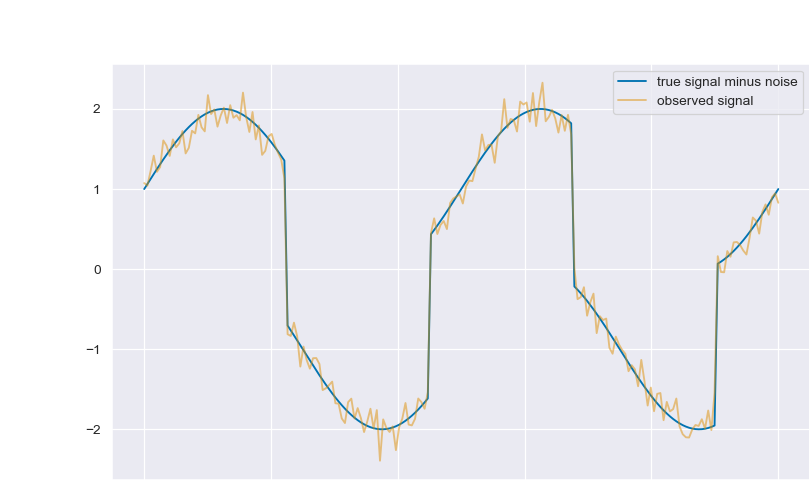

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# CVXPY + MOSEK

In [64]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
components = [c1, c2, c3]
problem1 = Problem(y, components)

In [65]:
problem1.decompose(admm=False)

In [66]:
problem1.objective_value

0.09502286307165887

<IPython.core.display.Javascript object>


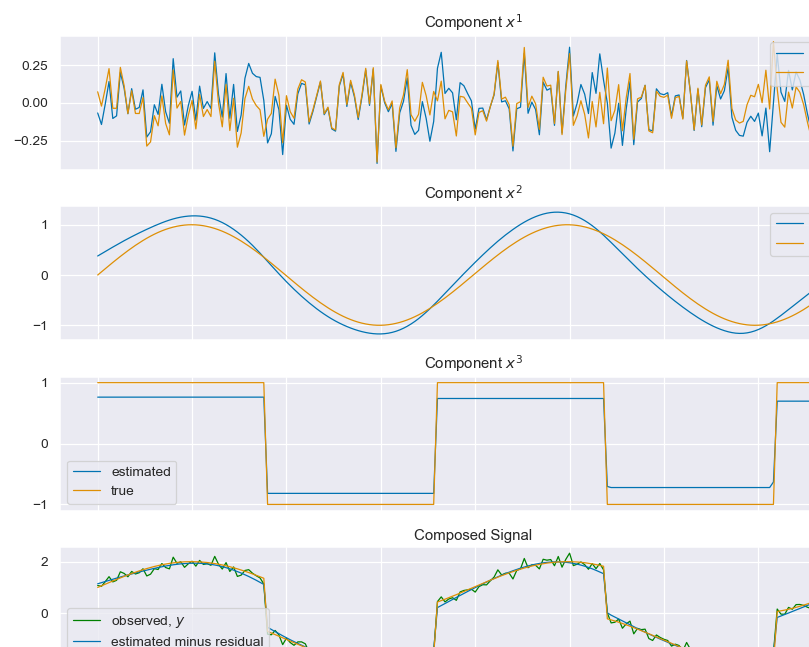

In [67]:
problem1.plot_decomposition(X_real=X_real);

# SD ADMM

In [68]:
problem2 = Problem(y, components)
problem2.decompose(admm=True, rho=2/T, num_iter=100)

[============================================================] 100.0% ...5.16 sec


<IPython.core.display.Javascript object>


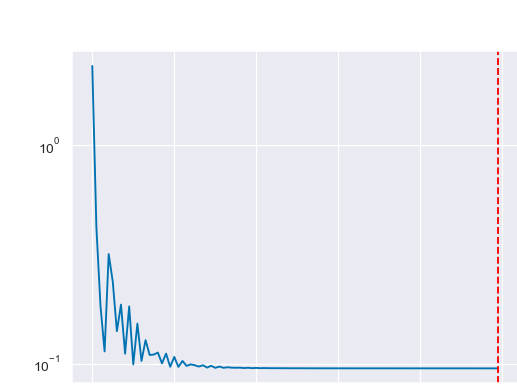

In [69]:
plt.figure()
plt.plot(problem2.admm_result['obj_vals'])
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


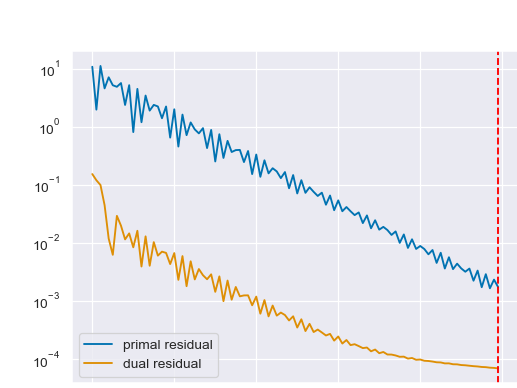

In [70]:
plt.figure()
plt.plot(problem2.admm_result['primal_r'], label='primal residual')
plt.plot(problem2.admm_result['dual_r'], label='dual residual')
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.show()

In [71]:
problem2.objective_value

0.09504294225784221

<IPython.core.display.Javascript object>


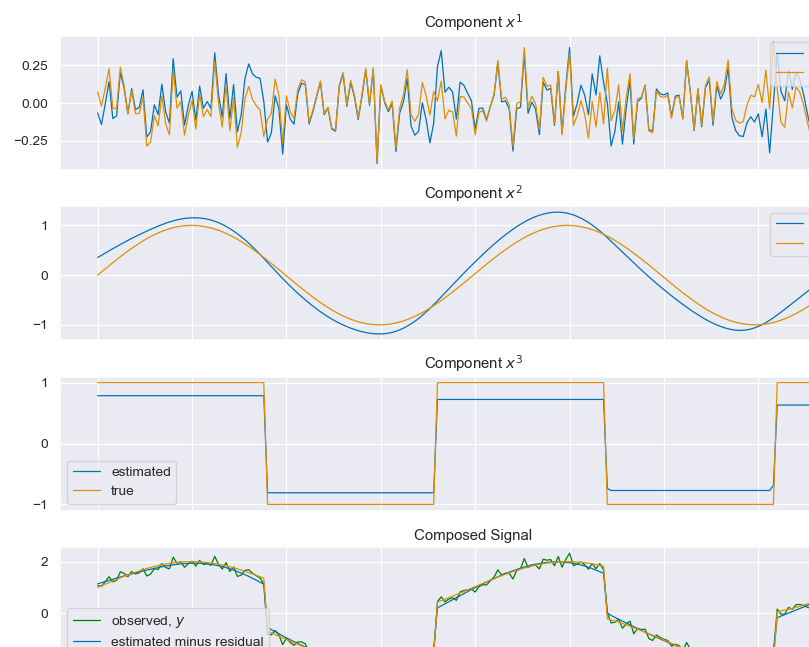

In [72]:
problem2.plot_decomposition(X_real=X_real);

# Coordinate Descent

In [73]:
problem3 = Problem(y, components)
results_bcd = run_bcd(problem3.data, problem3.components, num_iter=100)

<IPython.core.display.Javascript object>


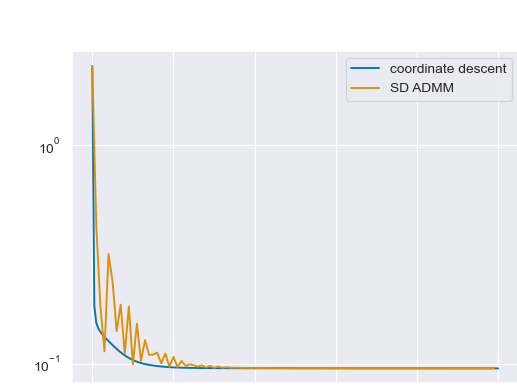

In [74]:
plt.figure()
plt.plot(np.arange(nit * 2 + 1) / 2, results_bcd['obj_vals'], label='coordinate descent')
plt.plot(problem2.admm_result['obj_vals'], label='SD ADMM')
plt.yscale('log')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


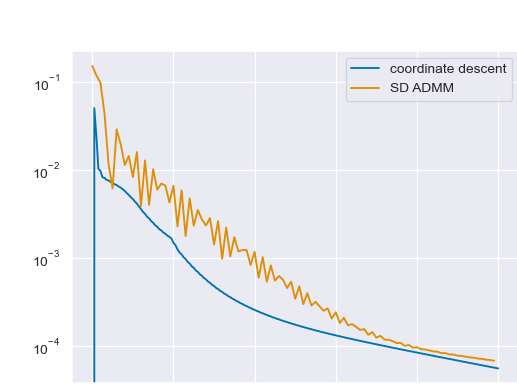

In [75]:
plt.figure()
plt.plot(np.arange(nit * 2 + 1) / 2, results_bcd['dual_r'], label='coordinate descent')
plt.plot(problem2.admm_result['dual_r'], label='SD ADMM')
plt.yscale('log')
plt.legend()
plt.show()

In [76]:
### Set up dummy problem object for plotting the coordinate descent decomposition
problem3.estimates = results_bcd['X']
problem3.use_set = np.ones_like(y, dtype=bool)

In [77]:
problem3.objective_value

0.09503033923769076

<IPython.core.display.Javascript object>


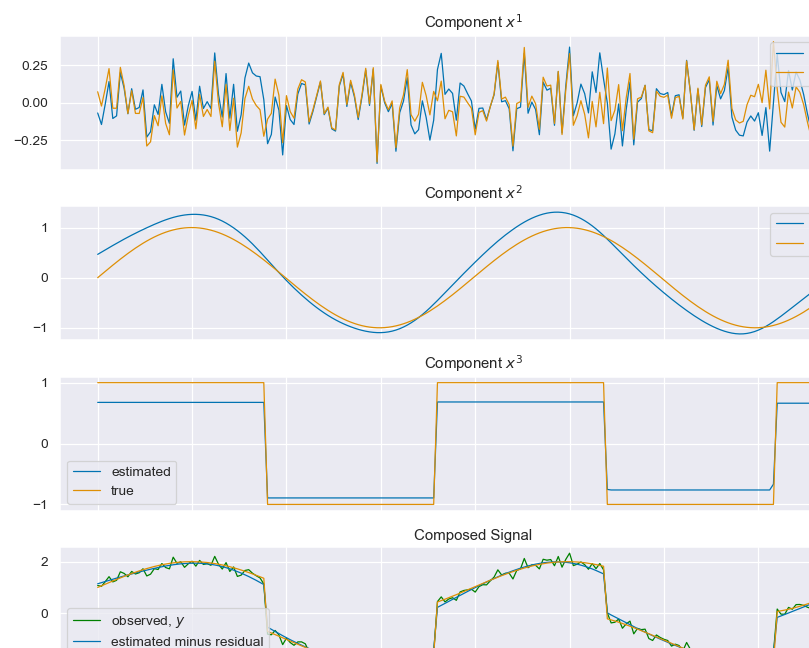

In [78]:
problem3.plot_decomposition(X_real=X_real);

### new work 9/16

- The dual variable is $-2/T$ times the first component
- The ADMM dual state variable converges to $1/\rho$ times the SD consistency dual variable

<IPython.core.display.Javascript object>


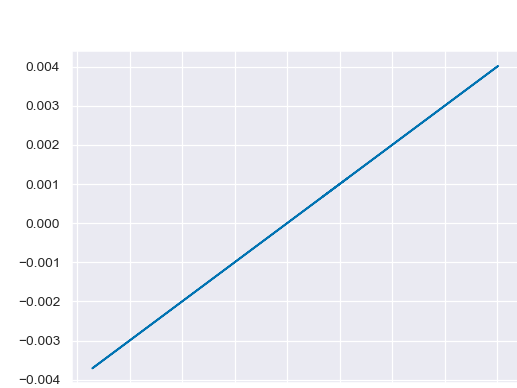

In [79]:
plt.figure()
plt.plot(problem1.problem.variables()[0].value * (-2 / T),
         problem1.problem.constraints[-1].dual_value)

<IPython.core.display.Javascript object>


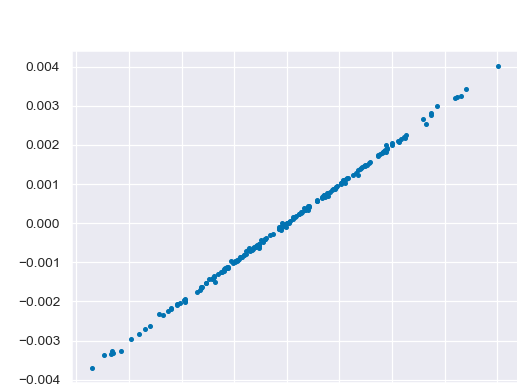

In [80]:

plt.figure()
plt.plot(problem2.admm_result['u'] * (2/T),
         problem1.problem.constraints[-1].dual_value,
        marker='.', ls='none')

<IPython.core.display.Javascript object>


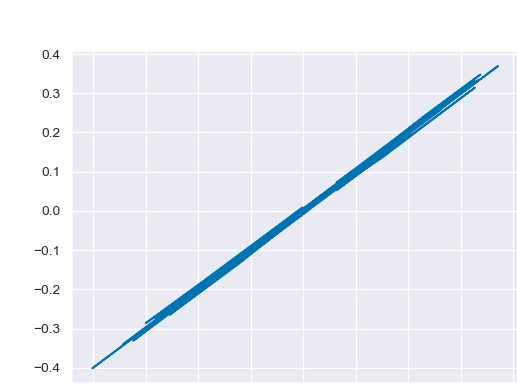

In [81]:
plt.figure()
plt.plot(problem1.problem.variables()[0].value,
         (-1) * problem2.admm_result['u']);